# [TPV3] Tweaking the blending function
by JN Hayek (Created on 09.12.2021)


In [1]:
import os, sys, math, time

from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter, MaxNLocator


sys.path.insert(0,"/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/LibFolder")
from Lib_GeneralFunctions import *
from Lib_GeneralSignalProcNAnalysis import *
from Lib_ProfilePlotting import *
from Lib_ProfileProcessing import *


#=================== Plotting style ===================
plt.style.use('science')

from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

#definition of colormap
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
from palettable.cartocolors.qualitative import Safe_3 as LineColor

cmap = ListedColormap(LineColor.mpl_colors[:])

In [2]:

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
def FontSizeControlFreak(SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE):
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Timestamp variable
start_time = time.time()

In [4]:
# Save into a class the 
class TPV3reference:
    def __init__(self, filename, coordinates, RefSource="SEM2DPACK"):
        
        line = pd.read_csv(filename.format("slip"), header=None)
        self.Time = line[0]
        self.Slip = line[1]
        
        line = pd.read_csv(filename.format("sr"), header=None)
        self.SlipRate = line[1]
        
        self.Coord = coordinates #Only used for labels and 
        self.RefSource = RefSource
    #end __init__
    
    # Default object printing information
    def __repr__(self):
        return "The TPV3reference object was generated from: {} and the receiver is located at {}".format(self.RefSource, self.Coord)
    #end __repr__
    
    def __str__(self):
        return "The TPV3reference object was generated from: {} and the receiver is located at {}".format(self.RefSource, self.Coord)
    #end __str__
    
    def PlotReference(self, ax, SlipSlipRate, filtering=True, **kwargs):
        
        if SlipSlipRate=="Slip":
            if(filtering):
                ax.plot(self.Time, Butterworth(self.Slip, **kwargs), label = "", c = "k", ls = "--", zorder=1)
            else:
                ax.plot(self.Time, self.Slip, label = "", c = "k", ls = "--", zorder=1)
        elif SlipSlipRate=="SlipRate":
            if(filtering):
                ax.plot(self.Time, Butterworth(self.SlipRate, **kwargs), label = "", c = "k", ls = "--", zorder=1)
            else:
                ax.plot(self.Time, self.SlipRate, label = "", c = "k", ls = "--", zorder=1)
            
        return ax

In [5]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/[TPV3]Results/"

# Reference saved into a list of objects
RefList = [TPV3reference(path + "Reference/sem2dpack/sem2d-{}-2.txt", "4km"),
           TPV3reference(path + "Reference/sem2dpack/sem2d-{}-3.txt", "6km"),
           TPV3reference(path + "Reference/sem2dpack/sem2d-{}-4.txt", "8km"),
          ]


RefList = [TPV3reference(path + "Reference/sem2dpack/[TPV3]sem2dpack-{}-receiver-4.0e+03.txt", "4km"),
           TPV3reference(path + "Reference/sem2dpack/[TPV3]sem2dpack-{}-receiver-6.0e+03.txt", "6km"),
           TPV3reference(path + "Reference/sem2dpack/[TPV3]sem2dpack-{}-receiver-8.0e+03.txt", "8km"),
          ]


In [6]:
def PlotReceiverFile(ax, ReceiverFile, ColIDX, OrderPeriodicity=8, NumReceivers=3, filtering=True, **kwargs):
    ylabeldict={1:"Slip [m]", 2:"Slip rate [m/s]", 3:"$\mu$"}
    
    if(filtering):
        CutoffFrequency = kwargs.get("CutoffFrequency",7)
        kwargs.pop("CutoffFrequency")
        
        SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0])
        [ax.plot(ReceiverFile[0], 
                 Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*i],SamplingFrequency = SamplingFrequency, CutoffFrequency = CutoffFrequency, **kwargs),color = cmap.colors[i], linewidth=2,
                 zorder=2,**kwargs) for i in range(NumReceivers)]
    else:
        [ax.plot(ReceiverFile[0], ReceiverFile[ColIDX+OrderPeriodicity*i],color= cmap.colors[i], linewidth=2, zorder=2,**kwargs) for i in range(NumReceivers)]
        
    ax.set_ylabel(ylabeldict[ColIDX])
    ax.set_xlabel("time [s]")
    return ax

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.set_xlim(0.0,7.0)
        ax.set_ylim(-0.5,7.0)
        
        
    Lines = fig.axes[-1].get_lines()[-4:]
    
    legend2 = fig.axes[-1].legend(Lines, ['Reference', '4km', '6km', '8km'], loc=1)
    fig.axes[-1].add_artist(legend2)

def GenericFigAxis():
    fig = plt.figure(constrained_layout=True, figsize=[12,5], dpi = 300)
    gs = GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    
    return fig, [ax1, ax2]

### Function for plotting 2 sets of graphs (filtered/unfiltered) from a ReceiverCP file

In [7]:
def PlotReceiverCP_wPandas(ReceiverFile, ParamsText, RefList, **kwargs):
    sliporsliprateDict={"Slip":1, "SlipRate": 2}
    
    #================= Plotting Filtered Set ===================#
    fig, axis = GenericFigAxis()
    PlotType = "Slip"
    [item.PlotReference(axis[0], PlotType, filtering=True, **kwargs) for item in RefList] #Reference
    PlotReceiverFile(axis[0], ReceiverFile, sliporsliprateDict[PlotType], filtering = True, **kwargs)

    PlotType = "SlipRate"
    [item.PlotReference(axis[1], PlotType, filtering=True, **kwargs) for item in RefList] #Reference
    PlotReceiverFile(axis[1], ReceiverFile, sliporsliprateDict[PlotType], filtering = True, **kwargs)

    format_axes(fig)
    
    if "CutoffFrequency" in kwargs:
        fig.suptitle("[TPV3] Filtered results ($f_c=${}$Hz$) {}".format(kwargs.get("CutoffFrequency"),ParamsText))
    else:
        fig.suptitle("[TPV3] Filtered results ($f_c=7Hz$) {}".format(ParamsText))

    #================= Plotting Non-Filtered Set ===================#
    fig, axis = GenericFigAxis()

    PlotType = "Slip"
    [item.PlotReference(axis[0], PlotType, filtering=False) for item in RefList] #Reference
    PlotReceiverFile(axis[0], ReceiverFile, sliporsliprateDict[PlotType], filtering = False)

    PlotType = "SlipRate"
    [item.PlotReference(axis[1], PlotType, filtering=False) for item in RefList] #Reference
    PlotReceiverFile(axis[1], ReceiverFile, sliporsliprateDict[PlotType], filtering = False)

    format_axes(fig)
    fig.suptitle("[TPV3] Unfiltered results {}".format(ParamsText))
    

## TPV3 Plots (P2)


In [8]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.set_xlim(0,7.0)
        ax.set_ylim(-0.5,7.0)
        
        
    Lines = fig.axes[-1].get_lines()[-4:]
    
    legend2 = fig.axes[-1].legend(Lines, ['Reference', '4km', '6km', '8km'], loc=1)
    fig.axes[-1].add_artist(legend2)


In [9]:
def PlotTimeProfileSetFlex(ax, Set,SlipSlipRate,title,Filtered = False, absolute = False, **kwargs):
    UnitsDict = {"Slip" : "Slip [m]", "SlipRate" : "Slip Rate [m/s]"}
    
    ax.set(xlabel = 'Time [s]', ylabel = UnitsDict[SlipSlipRate], 
           title = title)
    
    OrdinateVariableList=[]
    for idx,item in enumerate(Set):
        
        if (SlipSlipRate == "Slip"):
            OrdinateVariableList.append([a for a in item.DispX]) 
        elif (SlipSlipRate == "SlipRate"):
            OrdinateVariableList.append([a for a in item.VelX])

        if (Filtered):
            OrdinateVariableList[idx] = [a for a in Butterworth(OrdinateVariableList[idx])]

        if (absolute):
            OrdinateVariableList[idx] = [abs(a) for a in OrdinateVariableList[idx]]

    for idx,item in enumerate(Set):
        ax.plot(item.Time, OrdinateVariableList[idx], **kwargs)

def PlotFlexSpecificLegend(ax, ListOfFiles,SlipSlipRate,title,Filtered=True,**kwargs):
    for iidx,SingleFile in enumerate(ListOfFiles):
        head, tail = os.path.split(SingleFile)
        File = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        PlotTimeProfileSetFlex(ax, File, SlipSlipRate, title,Filtered,
                               zorder = iidx + 2, c = cmap(iidx/(len(ListOfFiles)+1)),
                               **kwargs )    

    return ax

In [10]:
def GenericFigAxis2():
    fig = plt.figure(constrained_layout=True, figsize=[10,5])
    gs = GridSpec(1, 1, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    
    
    return fig, [ax1]

def PlotReceiverCP_wPandasUnfiltered(ReceiverFile, ParamsText, RefList, **kwargs):
    sliporsliprateDict={"Slip":1, "SlipRate": 2}
    fig, axis = GenericFigAxis2()

    PlotType = "SlipRate"
    [item.PlotReference(axis[0], PlotType, filtering=False) for item in RefList] #Reference
    PlotReceiverFile(axis[0], ReceiverFile, sliporsliprateDict[PlotType], filtering = False, **kwargs)

    format_axes(fig)
    fig.suptitle("Unfiltered se2dr vs Unfiltered SEM2DPACK{}".format(ParamsText))
    
def PlotReceiverCP_wPandasFiltered(ReceiverFile, ParamsText, RefList, **kwargs):
    sliporsliprateDict={"Slip":1, "SlipRate": 2}
    fig, axis = GenericFigAxis2()

    PlotType = "SlipRate"
    [item.PlotReference(axis[0], PlotType, filtering=True, **kwargs) for item in RefList] #Reference
    PlotReceiverFile(axis[0], ReceiverFile, sliporsliprateDict[PlotType], filtering = True, **kwargs)

    format_axes(fig)
    if "CutoffFrequency" in kwargs:
        fig.suptitle("($f_c=${}$Hz$) Filtered se2dr vs Filtered SEM2DPACK{}".format(kwargs.get("CutoffFrequency"),ParamsText))
    else:
        fig.suptitle("($f_c=7Hz$) Filtered se2dr vs Filtered SEM2DPACK{}".format(ParamsText))
        
def PlotReceiverCP_wPandasAtAxis(ReceiverFile, ax, RefList, **kwargs):
    sliporsliprateDict={"Slip":1, "SlipRate": 2}

    PlotType = "SlipRate"
    [item.PlotReference(ax, PlotType, filtering=True, **kwargs) for item in RefList] #Reference
    PlotReceiverFile(ax, ReceiverFile, sliporsliprateDict[PlotType], filtering = True, **kwargs)

In [11]:
def GetRefSignal(RefList,NumReceiver,CutOffFreq):
    RefItem = RefList[NumReceiver]; print(RefItem)
    
    RefTimeSignal= RefItem.Time.tolist()
    RefSignal    = Butterworth(RefItem.SlipRate.tolist(), SamplingFrequency=1./(RefTimeSignal[1]-RefTimeSignal[0]), 
                            CutoffFrequency = CutOffFreq)
    
    # To NOT filter the reference as well
    #RefSignal    = RefItem.SlipRate.tolist()
    
    return RefTimeSignal,RefSignal

def GetReceiverPair_FromStation(Station,CutOffFreq):
    print("Receiver Coords:",Station.Coord)
    TimeSignal= Station.Time
    Signal    = Butterworth(Station.VelX, SamplingFrequency=1./(TimeSignal[1]-TimeSignal[0]), 
                            CutoffFrequency = CutOffFreq)
    
    return TimeSignal,Signal

# Error analysis approach

In [12]:
def GetMaxPeakValueNTiming_FromLists(TimeList,MagnList):
    idx = MagnList.index(max(MagnList))

    PeakValue = MagnList[idx]
    PeakTiming = TimeList[idx]

    return [PeakTiming,PeakValue]
    
def GetMaxPeakValueNTiming_FromLists_TimeCondition(TimeList,MagnList,TimeLim):
    idxLim = np.abs(np.array(TimeList) - TimeLim).argmin()
    
    idx = MagnList.index(max(MagnList[:idxLim]))

    PeakValue = MagnList[idx]
    PeakTiming = TimeList[idx]

    return [PeakTiming,PeakValue]
    
def GetDictDataReceiver(p, dx, ReceiverLoc, RefPair, ReceiverPair):
    ToAppendDict={"p": p,
                  "dx":  dx,
                  "ReceiverLoc": ReceiverLoc,
                  "TimingDifference": ReceiverPair[0]-RefPair[0], 
                  "SlipRateDifference":ReceiverPair[1]-RefPair[1]
                 }
    return ToAppendDict



def PlotnScatter3Lists(axis,x,y,z):
    axis.scatter(x, y)
    axis.plot(x, y,'o')
    for i, txt in enumerate(z):
        axis.annotate(txt, (x[i]+.005, y[i]-.005))
        
        
        

        
def PlotStuff(Data, path, File_k, RefList, CutOffFreq, NumReceiver):
    
    _Stations = LoadPickleFile(Filename=File_k[0],FolderPath=path)
    print("p =",File_k[1],", h =",File_k[2])
    
    fig = plt.figure(constrained_layout=True, figsize=[8,5])
    gs = GridSpec(1,1, figure=fig, wspace=0, hspace=0.)
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.set_title("p = {}, h = {}".format(File_k[1],File_k[2]))
    
    for i in range(NumReceiver):
        _RefTime,_RefSignal = GetRefSignal(RefList[::-1],i,CutOffFreq)
        _RecTime,_RecSignal = GetReceiverPair_FromStation(_Stations[i],CutOffFreq)
        
        _RefPair = GetMaxPeakValueNTiming_FromLists(_RefTime,_RefSignal)
        _ReceiverPair = GetMaxPeakValueNTiming_FromLists_TimeCondition(_RecTime,_RecSignal,3.2)
        
        _ToAppendDict = GetDictDataReceiver(File_k[1], "{h:03}m".format(h=File_k[2]), RefList[::-1][i].Coord, _RefPair, _ReceiverPair)

        print(_RefPair)
        print("Diff: ",_ToAppendDict["TimingDifference"])
        ax0.plot(_RefTime,_RefSignal, 'k--', _RecTime,_RecSignal, 'g-')
        
        ax0.scatter(_RefPair[0],_RefPair[1], marker='o',color= cmap.colors[i])
        ax0.scatter(_ReceiverPair[0],_ReceiverPair[1], marker='v',color= cmap.colors[i])
        


def Populate_PandasDF(Data, path, File_k, RefList, CutOffFreq, NumReceiver):
    
    _Stations = LoadPickleFile(Filename=File_k[0],FolderPath=path)
    print("p =",File_k[1],", h =",File_k[2])
    for i in range(NumReceiver):
        _RefTime,_RefSignal = GetRefSignal(RefList[::-1],i,CutOffFreq)
        _RecTime,_RecSignal = GetReceiverPair_FromStation(_Stations[i],CutOffFreq)
        
        _RefPair = GetMaxPeakValueNTiming_FromLists(_RefTime,_RefSignal)
        _ReceiverPair = GetMaxPeakValueNTiming_FromLists_TimeCondition(_RecTime,_RecSignal,3.2)

        _ToAppendDict = GetDictDataReceiver(File_k[1], "{h:03}m".format(h=File_k[2]), RefList[::-1][i].Coord, _RefPair, _ReceiverPair)
        
        Data = Data.append(_ToAppendDict, ignore_index=True)
        
    return Data



In [13]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
FontSizeControlFreak(SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE)

In [14]:
def GenericFigAxisExtra():
    fig = plt.figure(constrained_layout=True, figsize=[16,4])
    gs = GridSpec(1, 4, figure=fig, wspace=0, hspace=0.)
    
    gs00 = gs[0, 2:].subgridspec(1, 2,wspace=0, hspace=0.)
    
    
    
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs00[0, 0])
    ax3 = fig.add_subplot(gs00[0, 1])
    
    ax_right = fig.add_subplot(gs00[:]); ax_right.axis('off')
    ax_right.set_title('Blended')
    ax1.set_title('Non-Blended')

    ax3.set_yticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xlabel("Timing difference [s]")
    ax1.set_ylabel("Peak slip rate difference [m/s]")
    
    ax1.xaxis.set_major_locator(MaxNLocator(5))
    ax1.yaxis.set_major_locator(MaxNLocator(5))
    
    ax2.xaxis.set_major_locator(MaxNLocator(5))
    ax2.yaxis.set_major_locator(MaxNLocator(5))
    
    ax3.xaxis.set_major_locator(MaxNLocator(5))
    ax3.yaxis.set_major_locator(MaxNLocator(5))
    
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    
    return fig, ax0,[ax1, ax2,ax3]

In [15]:
path="/home/nico/Documents/Documents/SharedWolfel/PaperData/ConvTPV/20211209/"

Files = [["TEAR8_TPV_T0_P2_100x100_d1.001_CheckSteepBlend-Tilt0.0-P2-TPList_t1690_d100.1.pickle"  , 2, 100],
         ["TEAR8_TPV_T0_P2_050x050_d1.001_CheckSteepBlend-Tilt0.0-P2-TPList_t3390_d50.05.pickle"  , 2,  50],
         ["TEAR8_TPV_T0_P2_025x025_d1.001_CheckSteepBlend-Tilt0.0-P2-TPList_t6780_d25.025.pickle" , 2,  25],
         ["TEAR8_TPV_T0_P3_100x100_d1.001_CheckSteepBlend-Tilt0.0-P3-TPList_t3060_d100.1.pickle"  , 3, 100],
         ["TEAR8_TPV_T0_P3_050x050_d1.001_CheckSteepBlend-Tilt0.0-P3-TPList_t6130_d50.05.pickle"  , 3,  50],
         ["TEAR8_TPV_T0_P3_025x025_d1.001_CheckSteepBlend-Tilt0.0-P3-TPList_t9980_d25.025.pickle" , 3,  25]
        ]



Populating Dataframe
p = 2 , h = 100
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 8km
Receiver Coords: [8000.0, 100.1]
[2.8059745542538796, 5.28715164626519]
Diff:  0.11934240375287519
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 6km
Receiver Coords: [6000.0, 100.1]
[2.13833002636985, 4.618989705181397]
Diff:  0.1028402237159729
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 4km
Receiver Coords: [4000.0, 100.1]
[1.4566789699288, 3.9751895548803216]
Diff:  0.10034457223609095

p = 2 , h = 50
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 8km
Receiver Coords: [8000.0, 50.05]
[2.8059745542538796, 5.28715164626519]
Diff:  0.1075467708578528
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 6km
Receiver Coords: [6000.0, 50.05]
[2.13833002636985, 4.618989705181397]
Diff:  0.10284022371601242
The TPV

/home/nico/miniconda3/envs/jane/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]



p = 3 , h = 50
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 8km
Receiver Coords: [8000.0, 50.05]
[2.8059745542538796, 5.28715164626519]
Diff:  0.017387005918561016
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 6km
Receiver Coords: [6000.0, 50.05]
[2.13833002636985, 4.618989705181397]
Diff:  0.026464518612125065
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 4km
Receiver Coords: [4000.0, 50.05]
[1.4566789699288, 3.9751895548803216]
Diff:  0.0365076288690116

p = 3 , h = 25
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 8km
Receiver Coords: [8000.0, 25.025]
[2.8059745542538796, 5.28715164626519]
Diff:  0.00434607492496264
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 6km
Receiver Coords: [6000.0, 25.025]
[2.13833002636985, 4.618989705181397]
Diff:  0.013423587618526689
The TPV3reference obje

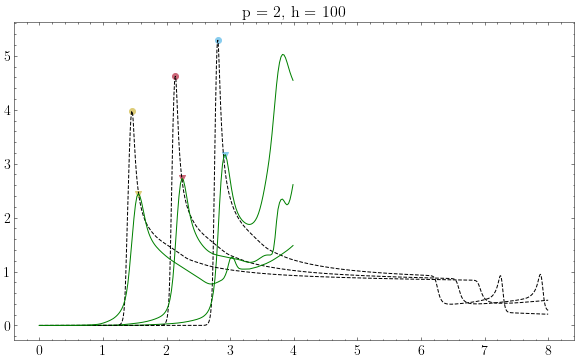

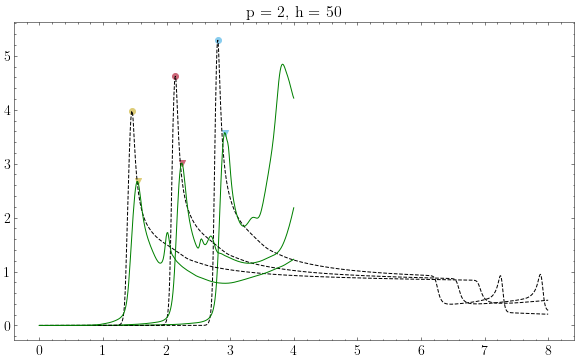

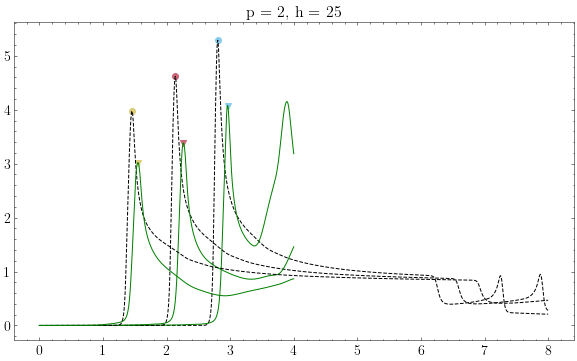

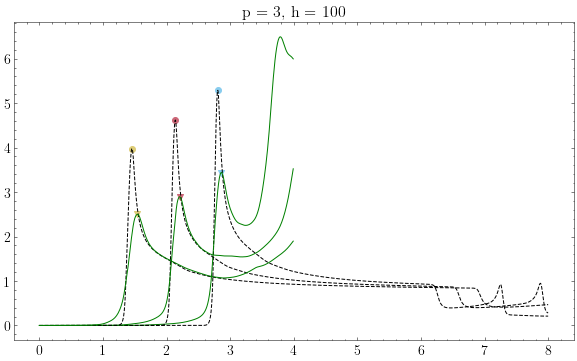

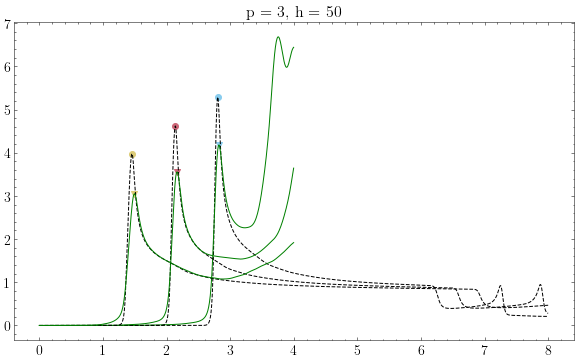

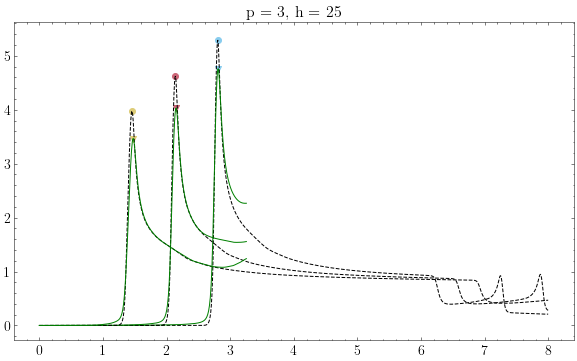

In [16]:

Data = pd.DataFrame(columns=["p","dx", "ReceiverLoc", "TimingDifference", "SlipRateDifference"])

NumReceiver = 3
CutOffFreq = 7

print("Populating Dataframe")
for File_k in Files:
    PlotStuff(Data, path, File_k, RefList, CutOffFreq, NumReceiver)
    #Populate_PandasDF(Data, path, File_k, RefList, CutOffFreq, NumReceiver)
    print("")
    


In [17]:
Data = pd.DataFrame(columns=["p","dx", "ReceiverLoc", "TimingDifference", "SlipRateDifference"])

print("Populating Dataframe")
for File_k in Files:
    #PlotStuff(Data, path, File_k, RefList, CutOffFreq, NumReceiver)
    Data = Populate_PandasDF(Data, path, File_k, RefList, CutOffFreq, NumReceiver)
    print("")

Populating Dataframe
p = 2 , h = 100
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 8km
Receiver Coords: [8000.0, 100.1]
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 6km
Receiver Coords: [6000.0, 100.1]
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 4km
Receiver Coords: [4000.0, 100.1]

p = 2 , h = 50
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 8km
Receiver Coords: [8000.0, 50.05]
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 6km
Receiver Coords: [6000.0, 50.05]
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 4km
Receiver Coords: [4000.0, 50.05]

p = 2 , h = 25
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 8km
Receiver Coords: [8000.0, 25.025]
The TPV3reference object was generated from: SEM2DPACK and the receiv

/home/nico/miniconda3/envs/jane/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


/home/nico/miniconda3/envs/jane/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


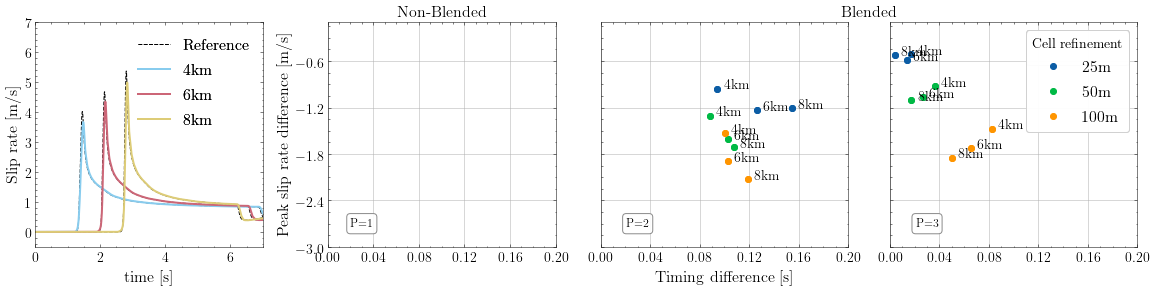

In [18]:
p1Data = Data[Data.p == 1]
p2Data = Data[Data.p == 2]
p3Data = Data[Data.p == 3]

fig,ax0,axis=GenericFigAxisExtra()
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

for j,PNumData in enumerate([p1Data,p2Data,p3Data]):
    Loc1Data = PNumData[PNumData.dx == "025m"]
    Loc2Data = PNumData[PNumData.dx == "050m"]
    Loc3Data = PNumData[PNumData.dx == "100m"]

    for LocNumData in [Loc1Data,Loc2Data,Loc3Data]:
        PlotnScatter3Lists(axis[j], 
                           LocNumData.TimingDifference.tolist(),
                           LocNumData.SlipRateDifference.tolist(),
                           LocNumData.ReceiverLoc.tolist())
    
    # Lines Formatting axis 1
    Lines = axis[2].get_lines()
    legend2 = axis[2].legend(Lines, ['25m', '50m', '100m'],title='Cell refinement',frameon=True)
    axis[2].add_artist(legend2)
    
    axis[j].text(0.03, -2.7, 'P={}'.format(j+1), ha="center", va="center", size=12,
            bbox=bbox_props)



    
for ax in axis:
    ax.set_xlim(.0,.2)
    ax.set_ylim(-3,-.1)

# AX0 PLOT
path0 = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/[TPV3]Results/"

ReceiverFile = pd.read_csv(path0+"20201012/TPV3/No6/receiverCP-dr-2400x2400-p3.dat", 
                           comment = '#',header = None, delimiter = " ")
    
PlotReceiverCP_wPandasAtAxis(ReceiverFile, ax0, RefList,CutoffFrequency=CutOffFreq)
ax0.set_xlim(0,7.0)
ax0.set_ylim(-0.5,7.0)
        
        
Lines = ax0.get_lines()[-4:]

legend2 = ax0.legend(Lines, ['Reference', '4km', '6km', '8km'], loc=1)
ax0.add_artist(legend2)